<a href="https://colab.research.google.com/github/eileenblum/Lyric-Generator/blob/main/Soft_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import numpy as np
import os
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

### New:
import tensorflow as tf

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras import layers
import time 

from keras import backend
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization

!pip install tensorflow_addons
!pip install sparse

import tensorflow_addons as tfa
from IPython import display
###

from nltk.stem import WordNetLemmatizer
from nltk.corpus import abc
from nltk.corpus import stopwords
from textblob import Word
sns.set_style("whitegrid")


     |████████████████████████████████| 706kB 8.8MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 


# **Data Loading**

In [ ]:
# Use this to load the dataframe, word corpus, and word list:

import pickle

with open("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_corpus.txt", "rb") as fp:
 Pro_Lyrics_corpus = pickle.load(fp)

with open("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_corpus_english.txt", "rb") as fp:
 Pro_Lyrics_corpus_english = pickle.load(fp)

with open("/content/drive/MyDrive/NLP bootcamp project/Pro Lyrics list.txt", "rb") as fp:
 Pro_Lyrics_list = pickle.load(fp)

Pro_Lyrics_df = pd.read_csv("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_df.csv")

In [ ]:
len(Pro_Lyrics_corpus)

233392

In [ ]:
len(Pro_Lyrics_df)

64082

In [ ]:
del Pro_Lyrics_df["Unnamed: 0"]
Pro_Lyrics_df.head()

,song_name,lyrics,type,cleaned_lyrics,words
0,1. The Moulting (Intro).txt,"""Throughout the fluid mass, but downward purge...",1.0,throughout fluid mass downward purged black ta...,"['throughout', 'fluid', 'mass', 'downward', 'p..."
1,3. Feed Them Hate.txt,What lies above nourishes the below. The waste...,1.0,lie nourishes waste excrement rot soil flowing...,"['lie', 'nourishes', 'waste', 'excrement', 'ro..."
2,2. Vehement Indulgences.txt,Sickening lives. Throes of squalor. Hollowed l...,1.0,sickening life throe squalor hollowed layer ab...,"['sickening', 'life', 'throe', 'squalor', 'hol..."
3,4. The Bottomless Perdition.txt,Womb of nature.\nSpoil and ruin.\nDeath yawn s...,1.0,womb nature\nspoil ruin\ndeath yawn seethes\nf...,"['womb', 'nature', 'spoil', 'ruin', 'death', '..."
4,3. Valley Of Defilement.txt,Rotten throne.\nCorrupted master.\nSending the...,1.0,rotten throne\ncorrupted master\nsending vacuo...,"['rotten', 'throne', 'corrupted', 'master', 's..."


In [ ]:
# This turns a sentence into a vector whose entries are the corpus indices of the words in the sentence, 
# ordered as they appear in the sentence.

def sent_to_vec(sentence, corpus):
  # corpus = Pro_Lyrics_corpus

  # cleaning (technically shouldn't to need since the input sentence is pre-cleaned):
  #sent = ' '.join(x for x in sentence.split() if x not in string.punctuation)
  #sent = sent.str.replace('[^\w\s]','')
  #sent = ' '.join(x.lower() for x in sent.split())
  #sent = ' '.join(x for x in sent.split() if  not x.isdigit())
  #sent = ' '.join(x for x in sent.split() if not x in stop)
  #sent = ' '.join([Word(word).lemmatize() for word in sent.split()])
  sent = sentence.split(" ")

  vec = []

  for i in range(len(sent)):
    if sent[i] in corpus:
      vec.append(corpus.index(sent[i]))

  return vec

In [ ]:
# This converts whole songs to lists of their lines (sentences).

def song_to_lines(song):
  lines = song.split("\n")

  return lines

# **Training Data Encoding**

Run the block of cells which has the input type you want. However, currently the architecture of the networks is setup for only the first two types (length $8$ input vectors).

## **Corpus-Index Encoded Length 8 Vectors, All Lines / All Corpus**

Here, and in the following encoding, we represent lines as vectors of length $8$, where the $i^{th}$ entry of such a vector $v$ is the corpus index of the $i^{th}$ word in $v$.

For example, the vector $(102, 1548, 0,0,0,0,0,0)$ would correspond to `Hello world` if the index of `Hello` in the corpus was $102$ and the index of `world` in the corpus was $1548$.

In [ ]:
# DON'T USE THIS, IT USES ENGLISH CORPUS BUT THE LINES HAVEN'T BEEN CLEANED FOR NON-ENGLISH LINES.

# Data Prep (takes about 90 min to run) use the next cell instead:

BUFFER_SIZE = 60000
BATCH_SIZE = 64

# Edit this!:

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

# need a corpus here:
train_sents = [sent_to_vec(line, Pro_Lyrics_corpus) for line in lines_list]

# lines in a song should be roughly 8 words long:
maxlen = 8

train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sents, maxlen=maxlen, padding='post').astype('float32')

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

with open("/content/drive/MyDrive/NLP bootcamp project/train_sents.txt", "wb") as fp:
  pickle.dump(train_sents, fp)

In [ ]:

# Run this instead. the "train_sents = [sent_to_vec(line, Pro_Lyrics_corpus) for line in lines_list]" is loaded first:

with open("/content/drive/MyDrive/NLP bootcamp project/train_sents.txt", "rb") as fp:
  train_sents = pickle.load(fp)

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

maxlen = 8

# We pad with 1059.0 here, as 1059 is the index of the string "" in the corpus.
train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sents, maxlen=maxlen, dtype = 'float32', padding='post', value = 1059.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

train_dataset = tf.data.Dataset.from_tensor_slices(train_sents_padded).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Corpus-Index Encoded Length 8 Vectors, English Lines / English Corpus**

This encoding is the same as the last, but we limit our lines and corpus to only contain words in the `nltk` English dictionary.

In [ ]:
# Cleaning the lines of non-english:

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)
english_lines_list = []
for line in lines_list:
  vec_line = line.split()
  c = True
  for word in vec_line:
    if word not in Pro_Lyrics_corpus_english:
      c = False
      break
  if c and (line != ""):
    english_lines_list.append(line)

# now only english lines


In [ ]:
print(len(english_lines_list))
print(len(lines_list))

# so almost 1/4 the size!

559603
2371452


In [ ]:
# Adding '' to the corpus so we can use it (in the case of our inputs being length 8 vectors of corpus indices)
Pro_Lyrics_corpus_english.append("")

In [ ]:
Pro_Lyrics_corpus_english.index("")

31489

In [ ]:
# USE THIS FOR ENGLISH VECTOR-LENGTH-8-CORPUS-INDEX INPUT (it uses english corpus AND non-english removed lines):

new_train_sents_english = [sent_to_vec(line, Pro_Lyrics_corpus_english) for line in english_lines_list]

# lines in a song should be roughly 8 words long:
maxlen = 8

train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(new_train_sents_english, maxlen=maxlen, dtype='float32', padding='post', value = 31489.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

with open("/content/drive/MyDrive/NLP bootcamp project/new_train_sents_english.txt", "wb") as fp:
  pickle.dump(new_train_sents_english, fp)

In [ ]:
# Run this instead. the "train_sents = [sent_to_vec(line, Pro_Lyrics_corpus_english) for line in english_lines_list]" is loaded first:

with open("/content/drive/MyDrive/NLP bootcamp project/new_train_sents_english.txt", "rb") as fp:
  new_train_sents_english = pickle.load(fp)

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

maxlen = 8

# We pad with 1059.0 here, as 1059 is the index of the string "" in the corpus.
train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(new_train_sents_english, maxlen=maxlen, dtype = 'float32', padding='post', value = 31489.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

train_dataset = tf.data.Dataset.from_tensor_slices(train_sents_padded).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Order Preserving One-Hot Encoded Length 16 Matrices, English Lines / English Corpus**

Here, each line is encoded as an $l_L \times l_C$ size matrix $M$, where $l_L$ is the line length and $l_C$ is the corpus length. For us, that means when converted to NumPy float64 arrays, each line is roughly $4$ Mb.

The lines are stored as follows: the $i^{th}$ word $w^i$ in the sentence is represented by a vector of length $l_C$, call it $v^i_C = (0,\dots,0,1,0,\dots,0)^\top$ with $1$ at the index where $w^i$ occurs in the corpus. Then, the first column of the matrix is the one-hot-encoded vector $v^1_C$ of the first word, and the second column is $v^2_C$ for the second word, and so on. Thus:
$$M = [v^1_C \enspace v^2_C \enspace \dots \enspace v^{l_L}_C]$$ 

We constrain our data to have $l_L = 16$ so that generated lines can be at most $16$ words long, but may be less if the later $v_C$ vectors contain all zeros.

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = sparse.COO(X)
    indices = coo.coords.transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
# NOTE: This takes 2-3 hours to run!
# This makes order-preserving one-hot-encoded matrices (scipy sparse) of the english lines (using english corpus):
# Note we say "one-hot-vector" often in this cell but these are always 2D matrices, not vectors.

import sparse
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

# Note: corpus and training lines are way too big to do this with Numpy arrays! 

maxlen = 16

#train_one_hot_vectors = lil_matrix((len(english_lines_list), maxlen, len(Pro_Lyrics_corpus_english)))
train_one_hot_vectors = sparse.DOK((len(english_lines_list), maxlen, len(Pro_Lyrics_corpus_english)))

for i in range(len(english_lines_list)):
  sent_vec = sent_to_vec(english_lines_list[i], Pro_Lyrics_corpus_english)
  for j in range(min(maxlen, len(sent_vec))):
    for k in range(len(Pro_Lyrics_corpus_english)):
      if sent_vec[j] == k:
        train_one_hot_vectors[i,j,k] = 1.0
        continue

BUFFER_SIZE = 60000
BATCH_SIZE = 64

# Saving:
sparse.save_npz("/content/drive/MyDrive/NLP bootcamp project/train_one_hot_sparse_matrix.npz", train_one_hot_vectors)

train_one_hot_tensors = convert_sparse_matrix_to_sparse_tensor(train_one_hot_vectors)

train_one_hot_tensors = tf.sparse.expand_dims(train_one_hot_tensors, axis = -1)
train_one_hot_tensors.shape


In [ ]:
train_one_hot_tensors.shape

train_dataset = tf.data.Dataset.from_tensor_slices(train_one_hot_tensors).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Run this instead: we load the pre-made train_one_hot_vectors from the above cell:

train_one_hot_vectors = sparse.load_npz("/content/drive/MyDrive/NLP bootcamp project/train_one_hot_sparse_matrix.npz")

BUFFER_SIZE = 60000
BATCH_SIZE = 64

train_one_hot_tensors = convert_sparse_matrix_to_sparse_tensor(train_one_hot_vectors)

train_one_hot_tensors = tf.expand_dims(train_one_hot_tensors, axis = -1)
train_one_hot_tensors.shape

train_dataset = tf.data.Dataset.from_tensor_slices(train_one_hot_tensors).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# **Function Definitions**

In [ ]:
# clip model weights to a given hypercube
from keras.constraints import Constraint

class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
# This is the "activation" after decoding, since the encoder and decoder will produce and train on float values.
# So any generated sentences must be run through this after being decoded.

# length is the length of the corpus for modular arithmetic.

def rectifier(T, length):
  m = np.array(T)
  new_m = np.zeros(np.shape(m))

  for idx, x in np.ndenumerate(m):
    new_m[idx] = round(x)

  new_m = new_m.astype(int)

  for idx, x in np.ndenumerate(new_m):
    modular_x = x % length
    new_m[idx] = modular_x

  return new_m


In [ ]:
# The one-hot order-preserving version of the rectifier. We use argmax for the choice of 
# which word appears in place i because the input will be tanh-activation rescaled to be in (0,1).
# T has shape (maxlen, len(Pro_Lyrics_corpus_english))

def ordered_one_hot_rectifier(T):
  m = np.array(T)
  new_m = np.zeros(np.shape(m))

  for i in range(m.shape[0]):
      new_m[i, np.argmax(m[i,:])] = 1.0

  new_m = new_m.astype(int)

  return new_m


In [ ]:
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 
# cross entropy loss for the encoder/decoder:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Or MSE loss for encoder/decoder:
MSE = tf.keras.losses.MeanSquaredError()

In [ ]:
def gradient_penalty(real, fake, epsilon): 
    #mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator1(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [ ]:
# Losses:
# Note: -1 = real, 1 = fake.

def discriminator_loss_total(real_output, fake_output, gradient_penalty):
    C_lambda = 10
    real_loss = wasserstein_loss(-1*tf.ones_like(real_output), real_output)
    fake_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss + C_lambda * gradient_penalty
    return total_loss

def discriminator_loss_real(real_output):
    real_loss = wasserstein_loss(-1*tf.ones_like(real_output), real_output)
    return real_loss

def discriminator_loss_fake(fake_output):
    fake_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
    return fake_loss

# Encoder/decoder losses:

def encoderdecoder_loss(discriminated_fake_decoded_encoded_output, discriminated_real_decoded_encoded_output):

    real_loss = MSE(discriminated_real_decoded_encoded_output, -1*tf.ones_like(discriminated_real_decoded_encoded_output))
    fake_loss = MSE(discriminated_fake_decoded_encoded_output, tf.ones_like(discriminated_fake_decoded_encoded_output))

    return real_loss + fake_loss


# **Network Architecture**

In [ ]:
# DCGANs usually use 100,000 - 500,000 iterations (epochs) for the generator...Colab pro?
EPOCHS = 10

noise_dim = 100
# make this a square (1,4,16,... etc.) for the subplotting code:
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# edit this:

# NOTE: LSTM layers can have masks! should we use?
# size used to be 512.
# input to LSTM: [batch, timesteps, features]

def make_encoder():
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(100, input_shape=(8,1)))  #input_shape=(None,8,1)?
  # Shape is now [64,100]

  # some reshaping here?
  model.add(layers.Reshape((100, 1)))

  model.add(tf.keras.layers.LSTM(100))


  return model

In [ ]:
# edit this:
def make_decoder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.RepeatVector(8, input_shape=(100,)))   #input_shape=(None,100) when applying decoder to something
  #model.add(tf.keras.layers.RepeatVector(233392)) #?????????
  model.add(tf.keras.layers.LSTM(100, return_sequences=True)) 

  # Makes it take too long if 512:
  model.add(tf.keras.layers.LSTM(100, return_sequences=True)) 

  # here we have a tanh activation (since all the LSTM layers do as well...could try sigmoid though)
  # since we want output to be restricted.
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = 'tanh')))

  return model

In [ ]:
# This is a generic discriminator, reducing dimension equally with each layer.

def make_discriminator_model1(r, dropout):
    # weight initialization
    init = RandomNormal(stddev=0.02)
	  # weight constraint
    const = ClipConstraint(0.01)
   
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 3, strides=2, padding='same', input_shape=[8, 1], kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [4, 1]

    model.add(layers.Conv1D(64, 1, strides=2, padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [2, 1]

    model.add(layers.Conv1D(128, 1, strides=2, padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [1, 1]

   # model.add(layers.Conv1D(256, (1, 1), strides=(2, 2), padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [1, 14587, 1]

    # What to do for this layer?
    #model.add(layers.Conv2D(512, (1, 1), strides=(1, 29), padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [1, 503, 1]

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

# **Training Loops**

In [ ]:

@tf.function
def encoderdecoder_train_step(batch):

  with tf.GradientTape() as ed_tape:
    encoded_batch = encoder(batch, training=True)
    decoded_encoded_batch = decoder(encoded_batch, training=True)

    # Resizing:
    # activation is tanh, and (0.5*(tanh(x) + 1) gives a probability in (0,1):
    decoded_encoded_batch = (0.5*(decoded_encoded_batch + 1)) * len(Pro_Lyrics_corpus_english)
    fake_output1 = discriminator1(decoded_encoded_batch, training=True)
    real_output1 = discriminator1(batch, training=True)

    # Can't do this, as we get "NotImplementedError: Cannot convert a symbolic Tensor (mul_1:0) to a numpy array."
    #decoded_encoded_batch = rectifier(np.array(decoded_encoded_batch), len(Pro_Lyrics_corpus_english))

    # Can't do this either, don't have kernel gradients???
    #decoded_encoded_batch = tf_rectifier(decoded_encoded_batch, tf.convert_to_tensor(Pro_Lyrics_corpus_english))

    # Here the encoder and decoder are trained as one:
    ed_loss = encoderdecoder_loss(fake_output1, real_output1)

  gradients_of_encoder_plus_decoder = ed_tape.gradient(ed_loss, encoder.trainable_variables + decoder.trainable_variables)

  encoderdecoder_optimizer.apply_gradients(zip(gradients_of_encoder_plus_decoder, encoder.trainable_variables + decoder.trainable_variables))

  return ed_loss

In [ ]:
@tf.function
def discrim_train_step(batch):
    noise = tf.random.normal([len(batch), noise_dim])

    with tf.GradientTape() as disc1_tape, tf.GradientTape() as ed_tape:
        encoded_batch = encoder(batch, training=True)
        decoded_encoded_batch = decoder(encoded_batch, training=True)
        decoded_encoded_batch = (0.5*(decoded_encoded_batch + 1)) * len(Pro_Lyrics_corpus_english)

        generated_batch = decoder(noise, training=True)
        generated_batch = (0.5*(generated_batch + 1)) * len(Pro_Lyrics_corpus_english)

        real_output1 = discriminator1(decoded_encoded_batch, training=True)
        fake_output1 = discriminator1(generated_batch, training=True)

        # do we want shape [len(batch), 100, 1] or [len(batch), 1, 1]???
        epsilon = tf.random.normal([len(batch), 1, 1], 0.0, 1.0)
        # We need the gradient penalty to happen at the encoded level:
        gp = gradient_penalty(decoded_encoded_batch, generated_batch, epsilon)

        disc1_loss = discriminator_loss_total(real_output1, fake_output1, gp)

        disc1_loss_r = discriminator_loss_real(real_output1)
        disc1_loss_f = discriminator_loss_fake(fake_output1)


    gradients_of_discriminator1 = disc1_tape.gradient(disc1_loss, discriminator1.trainable_variables)

    discriminator_optimizer1.apply_gradients(zip(gradients_of_discriminator1, discriminator1.trainable_variables))

    return disc1_loss, disc1_loss_r, disc1_loss_f

In [ ]:
# This trains the encoder/decoder:

def train(dataset, epochs):
  n_critic = 5
  c_hist, c_r_hist, c_f_hist, ed_hist = list(), list(), list(), list()
  count = 0

  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      c_tmp, c_r_tmp, c_f_tmp = list(), list(), list()

      for _ in range(n_critic):
        c_loss, c_r_loss, c_f_loss = discrim_train_step(batch)
        c_tmp.append(c_loss)
        c_r_tmp.append(c_r_loss)
        c_f_tmp.append(c_f_loss)

      c_hist.append(mean(c_tmp))
      c_r_hist.append(mean(c_r_tmp))
      c_f_hist.append(mean(c_f_tmp))

      ed_tmp = encoderdecoder_train_step(batch)
      ed_hist.append(ed_tmp)

      if count%1000 == 0:
        print('>%d, c1=%.3f, c1r=%.3f, c1f=%.3f, ed=%.3f' % (count+1, c_hist[-1], c_r_hist[-1], c_f_hist[-1], ed_hist[-1]))

      count += 1

    # Print a generated song line every epoch:
    #display.clear_output(wait=True)
    if (epoch + 1) % 1 == 0:
      generate_and_save(decoder, epoch + 1, seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_and_save(decoder, epochs, seed)

  return c_hist, c_r_hist, c_f_hist, ed_hist

In [ ]:
def decode_and_print(prediction_vec, corpus):
  sent = []
  for idx, word_index in np.ndenumerate(prediction_vec):
    sent.append(corpus[word_index])

  sentence = ""
  for word in sent:
    sentence = sentence + word + " "

  return sentence


In [ ]:
def decode_and_print_ordered_one_hot(prediction_matrix, corpus):
  sent = [""]*np.shape(prediction_matrix)[0]

  for i in range(np.shape(prediction_matrix)[0]):
    for j in range(np.shape(prediction_matrix)[1]):
      if prediction_matrx[i,j] == 1.0:
        sent[i] = corpus[j]

  sentence = ""
  for word in sent:
    sentence = sentence + word + " "

  return sentence

In [ ]:
def generate_and_save(model, epoch, test_input):
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        decoded_sent = predictions[i,:,0]

        # Resizing:
        decoded_sent = 0.5*(decoded_sent + 1) * len(Pro_Lyrics_corpus_english)

        #sentence = decode_and_print_ordered_one_hot(ordered_one_hot_rectifier(decoded_sent, 0.1), Pro_Lyrics_corpus_english)
        sentence = decode_and_print(rectifier(decoded_sent, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
        print(sentence)
        print()


        # Save the sentences/lines here?

# **Instantiating Models, Initial Tests**

In [ ]:
encoder = make_encoder()
decoder = make_decoder()
test_input = np.array(list(range(100)))

# decoder needs (None,100) as input:
test_input = tf.expand_dims(test_input, axis = 0)
test_output = decoder(test_input)

# Resizing:
test_output = 0.5*(test_output + 1) * len(Pro_Lyrics_corpus_english)

# want output shape to be [1, 8, 1]:
test_output.shape

TensorShape([1, 8, 1])

In [ ]:
test_output

<tf.Tensor: shape=(1, 8, 1), dtype=float32, numpy=
array([[[15847.129],
        [15868.886],
        [15882.329],
        [15904.282],
        [15936.86 ],
        [15979.769],
        [16032.119],
        [16092.548]]], dtype=float32)>

In [ ]:

discriminator1 = make_discriminator_model1(0.0001, 0.3)   # Dropout was 0.3 earlier

noise = tf.random.normal([1, 100])

S = decoder(noise, training=False)

decision1 = discriminator1(S)

print(np.array(decision1)[0][0])  #, np.array(decision2)[0][0], np.array(decision3)[0][0])
print()


-2.1017795e-05



In [ ]:
# A test of decoder(encoder):

ex_sent = new_train_sents_english[10543]
sentence = ""
for word_index in ex_sent:
  sentence = sentence + " " + Pro_Lyrics_corpus_english[word_index]
print(ex_sent)
print(sentence)

# NOTE: we should be padding with 1059, not 0! 1059 corresponds to ""!
ex_sent = ex_sent + [1059.0]*(8-len(ex_sent))
# note: we have to make this floats and pad with floats.
ex_sent = np.array(ex_sent).astype(float)

ex_sent = tf.expand_dims(ex_sent, axis = -1)
ex_sent = tf.expand_dims(ex_sent, axis = 0) #?

test_output2 = decoder(encoder(ex_sent))

# Resizing:
test_output2 = 0.5*(test_output2 + 1) * len(Pro_Lyrics_corpus_english)

print(test_output2)
print()
print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)))
print()
result = decode_and_print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
print(result)

[4463, 278, 2733]
 immortal power surge
tf.Tensor(
[[[15742.611]
  [15739.443]
  [15736.135]
  [15732.869]
  [15729.639]
  [15726.395]
  [15723.1  ]
  [15719.75 ]]], shape=(1, 8, 1), dtype=float32)

[[[15743]
  [15739]
  [15736]
  [15733]
  [15730]
  [15726]
  [15723]
  [15720]]]

introversion pontoon squid prophylactic clam calorie venal territorial 


# **Learning Rate Scheduling and Optimizers**

In [ ]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(initial_learning_rate=1e-4,
                                                             maximal_learning_rate=1e-3,
                                                             step_size=2000,
                                                             scale_mode="cycle",
                                                             gamma=0.96,
                                                             name="MyCyclicScheduler")

encoderdecoder_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
discriminator_optimizer1 = RMSprop(learning_rate=lr_schedule)

import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoderdecoder_optimizer=encoderdecoder_optimizer,
                                 discriminator_optimizer1=discriminator_optimizer1,
                                 discriminator1=discriminator1,
                                 encoder=encoder,
                                 decoder=decoder)

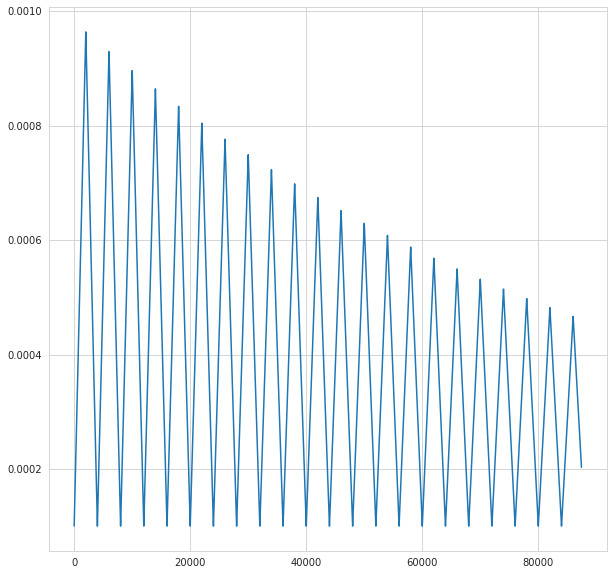

In [ ]:
# Plotting the learning rate:

length = EPOCHS * len(train_dataset)

y = [0] * length
for step in range(length):
  y[step] = lr_schedule.__call__(step)

plt.figure(figsize=(10,10))

plt.plot(y)
plt.show()

# **Training**

In [ ]:
c_hist, c_r_hist, c_f_hist, ed_hist = train(train_dataset, EPOCHS)

>1, c1=9.870, c1r=2.303, c1f=-2.431, ed=4.420
>1001, c1=-7845.005, c1r=-38.629, c1f=-7810.736, ed=24548306.000
>2001, c1=-13209.562, c1r=-53.527, c1f=-13156.755, ed=178587696.000
>3001, c1=-19526.400, c1r=-113.607, c1f=-19415.863, ed=234833440.000
>4001, c1=-23257.916, c1r=-243.823, c1f=-23018.316, ed=308300832.000
>5001, c1=-402.982, c1r=-7503.743, c1f=7098.482, ed=265581072.000
>6001, c1=-314.862, c1r=-5266.324, c1f=4950.036, ed=72275192.000
>7001, c1=-474.916, c1r=-6019.918, c1f=5540.865, ed=108056064.000
>8001, c1=-625.620, c1r=-6620.802, c1f=5985.205, ed=132560016.000
eschatological chi remodify infinitely vint suggesting excess genetics 

industrious geest crafty languish quagmire iris hedging spittle 

indrawn libel starboard salutation ectogenesis trepidation culture loophole 

hesitating hardhearted copping counter upsetting checked inherent assertiveness 

Time for epoch 1 is 557.767760515213 sec
>9001, c1=-388.868, c1r=-6497.914, c1f=6106.235, ed=176467104.000
>10001, c1=-56

# **Losses and Testing**

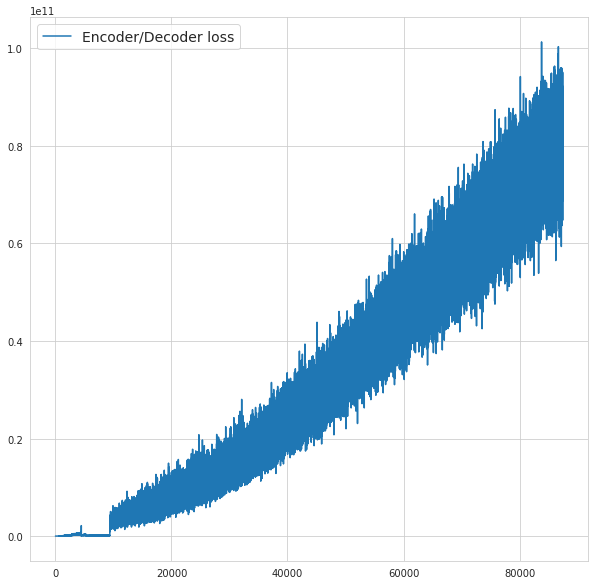

In [ ]:
# Plotting ED loss:

plt.figure(figsize=(10,10))

plt.plot(ed_hist, label="Encoder/Decoder loss")
plt.legend(fontsize=14)

plt.show()

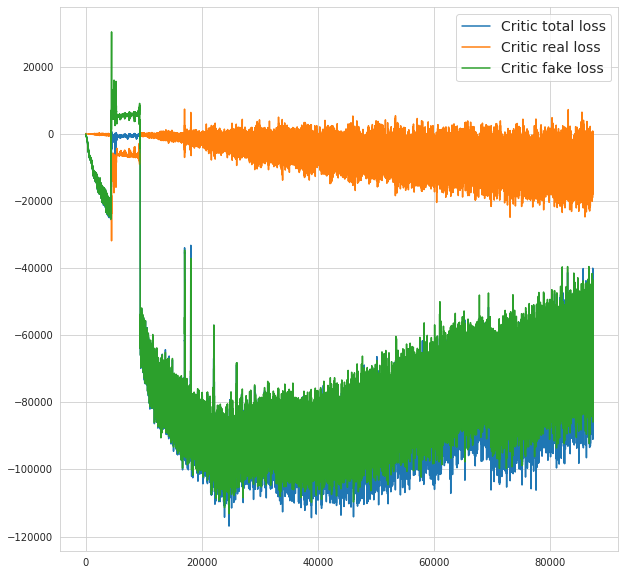

In [ ]:
# Plotting discriminator losses:

plt.figure(figsize=(10,10))

plt.plot(c_hist, label="Critic total loss")
plt.plot(c_r_hist, label="Critic real loss")
plt.plot(c_f_hist, label="Critic fake loss")
plt.legend(fontsize=14)

plt.show()

In [ ]:
# This shows some periodic behavior, possibly due to our cyclic learning rate. How to adjust?

In [ ]:
# A test of the trained decoder(encoder):

ex_sent = new_train_sents_english[10543]
sentence = ""
for word_index in ex_sent:
  sentence = sentence + " " + Pro_Lyrics_corpus_english[word_index]
print(ex_sent)
print(sentence)


# NOTE: we should be padding with 1059, not 0! 1059 corresponds to ""!
ex_sent = ex_sent + [1059.0]*(8 - len(ex_sent))
# note: we have to make this floats and pad with floats.
ex_sent = np.array(ex_sent).astype(float)

ex_sent = tf.expand_dims(ex_sent, axis = -1)
ex_sent = tf.expand_dims(ex_sent, axis = 0) #?

test_output2 = decoder(encoder(ex_sent))

# Resizing:
test_output2 = 0.5*(test_output2 + 1) * len(Pro_Lyrics_corpus_english)

print(test_output2)
print()
print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)))
print()
result = decode_and_print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
print(result)

[4463, 278, 2733]
 immortal power surge
tf.Tensor(
[[[14368.298 ]
  [13319.3   ]
  [12101.943 ]
  [11396.9795]
  [10894.483 ]
  [10479.479 ]
  [10330.242 ]
  [10220.517 ]]], shape=(1, 8, 1), dtype=float32)

[[[14368]
  [13319]
  [12102]
  [11397]
  [10894]
  [10479]
  [10330]
  [10221]]]

imaginate mosque windowpane flawlessly bloodstain curiously coexistence yellowish 


# **Saving Models**

In [ ]:
# SAVE the encoder/decoder models here:

encoder.save('/content/drive/MyDrive/NLP bootcamp project/softgan models/encoder.h5')
decoder.save('/content/drive/MyDrive/NLP bootcamp project/softgan models/decoder.h5')


In [ ]:
# SAVE the generator/discriminator here:

discriminator1.save('/content/drive/MyDrive/NLP bootcamp project/softgan models/discriminator1.h5')